In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

os.chdir('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/POS-Cross-Selling/Modelo_Supervisado')
import pipeline_bm as pipeline
#pd.set_option('display.max_row', 1000000)

pipeline_bm = pipeline.clase_pipeline()

c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Carga Data**

In [46]:
# Open the file in binary mode, remove null bytes, and then decode
with open('G:\\Mi unidad\\SOCOFAR\\0.-Recomendadores-Oficial\\Archivos\\SR_BASE_FINAL_PROD_FEB24.csv', 'rb') as file:
    content = file.read().replace(b'\x00', b'')  # Replace null bytes with nothing

# Convert the binary content to a string and use StringIO to mimic a file object for pandas
from io import StringIO
content_str = StringIO(content.decode('latin'))

# Now use pd.read_csv on the cleaned string data
df = pd.read_csv(content_str, sep=';', encoding='latin',nrows=1000000)
df['RUT_CLIENTE']=((df['SK']+1599)/2).astype(int)

In [36]:
diccionario=pd.read_csv('../diccionario_productos.csv',sep=';',usecols=['CODIGO','UNIDAD_COMERCIAL','MACROCATEGORIA','CATEGORIA_NIVEL_1','CATEGORIA_NIVEL_2_FCV','DESCRIPTOR_LARGO','MARCA'])

In [4]:
excl_otros = [str(elemento) for elemento in list(diccionario[diccionario.DESCRIPTOR_LARGO.isin(['DESPACHO','DESP.A','RETIRO DE RECETA','PROMOCION DTE','HORA VACUNACION','INSUMOS BOLSAS','SIN DESCRIPTOR','AJUSTE POR REDONDEO'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.DESCRIPTOR_LARGO.str.contains('BOLSA PAPEL|BOLS|DESPACHO|PROMOCION|CUPON|INYECCION|MEDICION|MEMBRESIA|REGALO|2020|2021|2022|MUNDIAL')]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.MACROCATEGORIA.isin(['ENFERMERIA ACCESORIOS Y PROCEDIMIENTOS','HOGAR','RECARGAS VARIAS','BEBIDAS Y AGUAS','ACCESORIOS MODA','TECNOLOGIA','AUTOLIQUIDABLES REGALO ARTICULOS VARIOS','INSUMOS MACRO','EQUIPOS QUIRURGICOS','POR CLASIFICAR'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.CATEGORIA_NIVEL_1.isin(['MASCARILLAS PRIMEROS AUXILIOS'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.UNIDAD_COMERCIAL.isin(['INSTITUCIONAL'])]['CODIGO'])]
#por código
cods_excluir = pd.read_csv('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/Archivos/codigos_exclusion.csv',sep=';').excluir.values.tolist() + excl_otros
cods_excluir = [int(cod) for cod in cods_excluir]

diccionario=diccionario[~diccionario.CODIGO.isin(cods_excluir)]

dicc_uam=df['CODIGO_PRODUCTO'].unique()
dicc_productos=diccionario[diccionario.CODIGO.isin(dicc_uam)].CODIGO

df=df[df.CODIGO_PRODUCTO.isin(dicc_productos)]
len(df)

491278

**Generación de Embedding de Clientes y Productos**

In [47]:
# AGRUPAR PRODUCTOS COMPRADOS POR CLIENTE EN LISTAS

# OPC1) METODO PARA PONDERAR PESO POR CANTIDAD
#sentences = df.groupby('RUT_CLIENTE')['CODIGO_PRODUCTO'].apply(list).tolist()

# OPC2) METODO PARA PONDERAR PESO POR CANTIDAD
df['PRODUCTO_CANTIDAD'] = df.apply(lambda row: [(row['CODIGO_PRODUCTO'], row['SUM_NRO_PROD'])], axis=1)

def expandir_productos_con_cantidad(lista_de_pares):
    resultado = []
    for producto, cantidad in lista_de_pares:
        resultado.extend([producto] * cantidad)
    return resultado

# Aplicar la función para expandir los productos según su cantidad
sentences = df.groupby('RUT_CLIENTE')['PRODUCTO_CANTIDAD'].sum().apply(expandir_productos_con_cantidad).tolist()

In [55]:
# Entrenar el modelo Word2Vec
model = Word2Vec(sentences, vector_size=10, window=5, min_count=1, workers=4)

In [56]:
#CALCULA EL EMBEDDING DEL CLIENTE SEGUN LOS PRODUCTOS QUE HA COMPRADO
client_embeddings = {}
for rut, group in df.groupby('RUT_CLIENTE'):
    products = group['CODIGO_PRODUCTO'].tolist()
    embeddings = []
    for product in products:
        embeddings.append(model.wv[product])
        
    if embeddings:
        client_embeddings[rut] = np.mean(embeddings, axis=0)

**Muestreo Estratificado**

In [8]:
caracteristicas=pd.read_csv('../SR_CARACTERISTICAS.CSV',sep=';')
df=df.merge(caracteristicas, how='left', on='RUT_CLIENTE')
df['EDAD'].replace(-1, np.nan,inplace=True)

In [9]:
min = df['EDAD'].min()
max = df['EDAD'].max()
tramos_edad = np.linspace(min, max, num=10)

df['EDAD_TRAMOS'] = pd.cut(df['EDAD'], bins=tramos_edad, include_lowest=True).astype(str)

# Específicamente asignar un tramo para NaN
df.loc[df['EDAD'].isna(), 'EDAD_TRAMOS'] = 'DESCONOCIDA'

In [10]:
n_muestra=len(df)*0.1 #TAMAÑO ESPERADO para determinar minimo de casos que debe haber en la categoría menos frecuente
proporcion=(n_muestra/len(df))*100
print( 'Porcentaje que representa la muestra sobre el dataset completo: '+ str(round(proporcion,2)) + '%')
freq_min=100/proporcion
print('Aparición minima de veces de una combinatoria para ser representada en la muestra: ' +str(int(freq_min)))

Porcentaje que representa la muestra sobre el dataset completo: 10.0%
Aparición minima de veces de una combinatoria para ser representada en la muestra: 10


In [11]:
#Identificar indices de casos con muy baja ocurrencia
conteos = df.groupby(['GENERO', 'GSE', 'EDAD_TRAMOS','CODIGO_PRODUCTO']).size()
# Filtrar las combinaciones con menos de "freq_min" apariciones
conteos_filtrados = conteos[conteos >= freq_min]
# Filtrar el DataFrame original para mantener solo las filas con combinaciones frecuentes
df_filtered = df[df.set_index(['GENERO', 'GSE', 'EDAD_TRAMOS','CODIGO_PRODUCTO']).index.isin(conteos_filtrados.index)].reset_index(drop=True)
print('tamaño dataset estratificado: '+str(len(df_filtered)))

tamaño dataset estratificado: 141979


In [12]:
n_muestra=len(df_filtered)*0.5 #TAMAÑO EFECTIVO de la muestra sobre el dataset filtrado
porc_muestra=n_muestra/len(df_filtered) #porcentual
tamaño_muestra = porc_muestra #porcentual
test_size=1-tamaño_muestra ##porcentual
df_estratificado, _ = train_test_split(df_filtered, test_size=test_size, stratify=df_filtered[['GENERO', 'GSE', 'EDAD_TRAMOS','CODIGO_PRODUCTO']])

df=df_estratificado
print('Tamaño de la muestra final: '+ str(len(df)))

Tamaño de la muestra final: 70989


In [13]:
#DATASET NIVEL CLIENTE CON RESPECTIVO EMBEDDING
df_cli_embedd = pd.DataFrame.from_dict(client_embeddings, orient='index')
df_cli_embedd.reset_index(inplace=True)
df_cli_embedd.columns = ['RUT_CLIENTE'] + [f'embedding_{i}' for i in range(model.vector_size)]      
print('N° de clientes: '+str(len(df_cli_embedd))) 

#CONSIDERAR SOLO CLIENTES DEL MUESTREO ESTRATIFICADO
df_cli_embedd=df_cli_embedd[df_cli_embedd.RUT_CLIENTE.isin(df.RUT_CLIENTE.unique())] 
df_cli_embedd.head(1)

N° de clientes: 444987


,RUT_CLIENTE,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9
417,1765298,-0.865048,1.345426,2.614072,-0.614402,2.199296,-1.638381,1.063702,1.296247,-1.648741,2.709008


In [14]:
df_inter_cli_embedd = pd.merge(df[['RUT_CLIENTE','CODIGO_PRODUCTO']], df_cli_embedd, on='RUT_CLIENTE', how='left')
print('N° de interacciones cliente/producto: '+str(len(df)))  
df_inter_cli_embedd.head(1)

N° de interacciones cliente/producto: 70989


,RUT_CLIENTE,CODIGO_PRODUCTO,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9
0,8131010,85948,-1.587042,0.225397,0.432841,-0.270807,1.619256,0.927332,0.058645,-0.580198,-2.309233,1.186118


In [15]:
dicc_prod_final=df_filtered.CODIGO_PRODUCTO.unique()
embeddings = [model.wv[producto] for producto in dicc_prod_final if producto in model.wv]
dicc_prod_embedd = pd.DataFrame(embeddings, index=dicc_prod_final)
dicc_prod_embedd.reset_index(inplace=True)
dicc_prod_embedd.rename(columns={'index': 'CODIGO_PRODUCTO'}, inplace=True)
dicc_prod_embedd.columns = ['CODIGO_PRODUCTO'] + [f'embedding_prod_{i}' for i in range(model.vector_size)]   
print('Cantidad de abanico de productos: '+str(len(df.CODIGO_PRODUCTO.unique()))) 
dicc_prod_embedd.head(1)

Cantidad de abanico de productos: 1043


,CODIGO_PRODUCTO,embedding_prod_0,embedding_prod_1,embedding_prod_2,embedding_prod_3,embedding_prod_4,embedding_prod_5,embedding_prod_6,embedding_prod_7,embedding_prod_8,embedding_prod_9
0,259839,-3.583851,0.330849,-0.326282,0.198948,0.869718,-0.346555,5.477843,-1.840533,1.321535,1.610932


**GENERACIÓN DATASET ENTRENAMIENTO (embedding como variables explicativas)**

**Consolidación casos target=1 (todos)**

In [16]:
df_cli_prod_embedd_t1 = pd.merge(df_inter_cli_embedd, dicc_prod_embedd, on='CODIGO_PRODUCTO', how='left')
df_cli_prod_embedd_t1['TARGET']=1
print('N° de interacciones cliente/producto: '+str(len(df_cli_prod_embedd_t1)))  
df_cli_prod_embedd_t1.head(1)

N° de interacciones cliente/producto: 70989


,RUT_CLIENTE,CODIGO_PRODUCTO,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_prod_1,embedding_prod_2,embedding_prod_3,embedding_prod_4,embedding_prod_5,embedding_prod_6,embedding_prod_7,embedding_prod_8,embedding_prod_9,TARGET
0,8131010,85948,-1.587042,0.225397,0.432841,-0.270807,1.619256,0.927332,0.058645,-0.580198,...,0.225397,0.432841,-0.270807,1.619256,0.927332,0.058645,-0.580198,-2.309233,1.186118,1


**Consolidación casos target=0 (muestra)** 

###### Opción 1) muestreo aleatorio=0
###### - para cada cliente de la tabla "df_cli_embedd" se le asocie aleatoriamente un registro de la tabla "dicc_prod_embedd"

In [17]:
n = 2  # Número de veces que deseas duplicar los clientes
df_cli_prod_embedd_t0 = pd.concat([df_cli_embedd] * n, ignore_index=True)

# Paso 1: Generar índices aleatorios
num_clientes = len(df_cli_prod_embedd_t0)
indices_aleatorios = np.random.choice(dicc_prod_embedd.index, size=num_clientes, replace=True)

# Paso 2: Asignar registros aleatorios a clientes
for columna in dicc_prod_embedd.columns:
    # Usar los índices aleatorios para seleccionar los valores de dicc_prod_embedd y asignarlos a df_cli_embedd
    df_cli_prod_embedd_t0[f'{columna}'] = dicc_prod_embedd.loc[indices_aleatorios, columna].values

In [18]:
# Paso 3: Eliminar posibles casos target=1
df_cli_prod_embedd_t0 = pd.merge(df_cli_prod_embedd_t0, df[['RUT_CLIENTE','CODIGO_PRODUCTO']], on=['RUT_CLIENTE','CODIGO_PRODUCTO'], how='left', indicator=True).loc[lambda x: x['_merge'] == 'left_only']
df_cli_prod_embedd_t0 = df_cli_prod_embedd_t0.drop(columns=['_merge']) #elimina aquellos que si cruzan en el historico de transacciones
df_cli_prod_embedd_t0['TARGET']=0

###### Opción 2) Muestreo Representativo por clusters
###### Distribuir equitativamente las muestras de productos no comprados entre clientes de perfil similar, y asi no requerir que para cada cliente se consideren todos los productos que no compra.
###### - Generar 'n' clusters
###### - A cada cluster asociar aleatoriamente los 'm' productos existentes en el diccionario (cumpliendo condición de que el cliente asociado no haya comprado el producto)
###### - los 'm' productos se pueden multiplicar por un factor 'x' dependiendo de la cantidad de casos con target=0 se definan, ya sea que se opte por un entrenamiento balanceado u otro superior.

In [19]:
############## PENDIENTE ##############

**Consolidación dataset**

In [20]:
# Mover la columna
columnas = list(df_cli_prod_embedd_t0.columns)
columnas.remove('CODIGO_PRODUCTO') 
columnas.insert(1,'CODIGO_PRODUCTO')
df_cli_prod_embedd_t0 = df_cli_prod_embedd_t0[columnas]

In [21]:
pipeline_bm.dataset = pd.concat([df_cli_prod_embedd_t0,df_cli_prod_embedd_t1],axis=0)
len(pipeline_bm.dataset)

210042

In [22]:
# dicc_prod_final=df_filtered.CODIGO_PRODUCTO.unique()
# pipeline_bm.dataset = pd.DataFrame()
# # Iterar sobre cada producto para construir el dataframe completo
# for i, producto in enumerate(dicc_prod_final, start=1):
#     product_embedding = model.wv[producto]
        
#     # Crear un DataFrame temporal que repite el embedding del producto para cada cliente
#     temp_df = pd.DataFrame([product_embedding], columns=[f'product_embedding_{i}' for i in range(len(product_embedding))])
#     temp_df = pd.concat([client_embeddings_df, temp_df.loc[temp_df.index.repeat(client_embeddings_df.shape[0])].reset_index(drop=True)], axis=1)
        
#     # Agregar una columna para el producto actual
#     temp_df['producto'] = producto
      
#     # Concatenar al dataframe completo
#     pipeline_bm.dataset = pd.concat([pipeline_bm.dataset, temp_df], ignore_index=True)
#     print(i)

In [23]:
# #Cruce con dataset de compras para marcaje de target = 1 cuando cliente ha comprado producto
# pipeline_bm.dataset['target'] = 0
# pipeline_bm.dataset = pipeline_bm.dataset.merge(df, how='left', left_on=['RUT_CLIENTE', 'producto'], right_on=['RUT_CLIENTE', 'CODIGO_PRODUCTO'])
# pipeline_bm.dataset['target'] = pipeline_bm.dataset['CODIGO_PRODUCTO'].notna().astype(int)
# pipeline_bm.dataset.drop(columns=['CODIGO_PRODUCTO','SK','SUM_NRO_PROD'], inplace=True)

In [24]:
excluir = ['RUT_CLIENTE', 'TARGET','CODIGO_PRODUCTO']
columnas_para_redondear = [col for col in pipeline_bm.dataset.columns if col not in excluir and (pipeline_bm.dataset[col].dtype == 'float64' or pipeline_bm.dataset[col].dtype == 'float32')]
pipeline_bm.dataset[columnas_para_redondear] = pipeline_bm.dataset[columnas_para_redondear].round(8)
pipeline_bm.dataset.head()     

,RUT_CLIENTE,CODIGO_PRODUCTO,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_prod_1,embedding_prod_2,embedding_prod_3,embedding_prod_4,embedding_prod_5,embedding_prod_6,embedding_prod_7,embedding_prod_8,embedding_prod_9,TARGET
0,1765298,251771,-0.865048,1.345426,2.614072,-0.614402,2.199296,-1.638381,1.063702,1.296247,...,1.615576,-0.996928,-0.221618,2.282088,-0.754981,-0.505653,-2.469895,-2.115952,2.469080,0
1,1837171,141087,-2.548579,1.031454,-0.692659,0.701824,2.903084,-2.901527,0.573037,-0.940731,...,0.494455,0.001649,-0.759172,0.142937,-0.533344,1.170948,0.287480,-1.152994,0.643762,0
2,1961897,398726,-0.537291,0.231428,-1.605616,3.997919,-1.898082,-1.982242,4.005368,-2.296108,...,1.558349,1.145885,2.760182,1.898842,-2.314275,0.061715,0.754791,0.571142,2.877932,0
3,2020803,296312,-3.828472,3.259140,-0.581277,-0.141592,0.945717,-1.865551,0.137845,3.258585,...,2.022788,1.323970,-0.549748,0.726829,-2.063492,0.197300,-0.698535,-1.064502,1.338840,0
4,2033026,300616,-1.217502,0.484676,1.881093,3.161570,2.743997,-0.072541,0.389887,-1.537163,...,0.222138,0.287127,0.073024,1.066841,0.205953,0.766113,-0.296225,-0.703949,0.812559,0


#### **Modelación**

In [25]:
pipeline_bm.recibe_data(
    tipo = 'dataframe',
    dataset_o_query = '',
    target = 'TARGET',
    delimiter=';' ,
    #muestra = 'MUESTRA',
    #ano_mes = 'FECHA_VENTA',
    rut = 'RUT_CLIENTE', 
    excluir=['CODIGO_PRODUCTO'],
    categoricas=[]
)

Procesando...
cargar previamente pipeline_bm.dataset = nombre_dataframe
________________________________________________________________________________________________________________________
Datos recibidos: OK.
Número de filas y columnas del dataset: (210042, 23)
________________________________________________________________________________________________________________________


In [26]:
pipeline_bm.separa_muestras(test=0.3)

Separacion de muestras: OK.
________________________________________________________________________________________________________________________


In [27]:
pipeline_bm.modelacion('RandomForest', perf_eval='f1',ruta_exporta='G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/POS-Cross-Selling/Modelo_Supervisado/modelo_rf.joblib')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=50, n_jobs=-1, oob_score=True, random_state=0;, score=0.968 total time=  10.9s
[CV 2/3] END bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=50, n_jobs=-1, oob_score=True, random_state=0;, score=0.969 total time=   4.7s
[CV 3/3] END bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=50, n_jobs=-1, oob_score=True, random_state=0;, score=0.968 total time=   4.5s
best params: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 50, 'n_jobs': -1, 'oob_score': True, 'random_state': 0}
best estimator: RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=0)
ROC: 0.997183983269317
Modelación: OK.
________________________________________________________________________________________________________________________


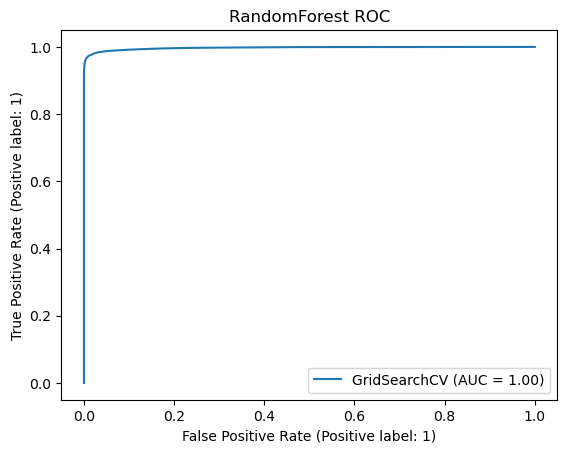

In [28]:
%matplotlib inline
plot_roc_curve(pipeline_bm.model, pipeline_bm.X_test, pipeline_bm.Y_test)
plt.title(pipeline_bm.algoritmo + ' ROC')
plt.show()

In [29]:
pipeline_bm.metricas_modelo_optimo()
pipeline_bm.confusion_matrix

"ROC OPTIMO"

sens+espc:  1.9627949126349629
KS:  0.9627949126349629
threshold optimo:  0.319
sensibility:  0.9727191623233319
specificity:  0.990075750311631
precision:  0.9804070042593469
negative predictive value:  0.9861280233030107
Critical Success Index:  0.954170696881765
accuracy:  0.984209607541301
f1score:  0.9765479529544865
BalancedAccuracy:  0.9813974563174814


TARGET,0,1
pred,,
0,41302,581
1,414,20716


Lo esperable es que el modelo ajuste muy bien ya que se le proporcionan implicitamente lo productos que compró a través del embedding del cliente. 
Lo importante acá es que, de cara al uso, la probabilidad hacia un producto no comprado por el cliente será más alta en la medida en que el embedding del cliente contenga el resto de productos que normalmente los clientes compran junto con el.

No confundir el acierto del modelo en el conjunto de test con el grado de efectividad esperado en las recomendaciones. Para esto último se puede realizar una aproximación más realista mediante una evaluación "offline" en un conjunto de datos OOT.

**USO DEL MODELO RECOMENDADOR**

- se recibe el cliente y producto buscado
- se calcula el embedding del cliente como la ponderacion de items historicos + el nuevo
- se calcula la probabilidad de compra para ese embedding en combinatoria con todos los embedding de productos existentes
- se seleccionan aquellos "n" con probabilidad más alta (sin compra previa)

In [66]:
#[rut_cliente,producto-1,...,producto-n]
vector=[1768451,261034,277430,253352]
cliente=vector[0]
productos=vector[1:]

embedding cliente

In [67]:
historico=df[df.RUT_CLIENTE==cliente].CODIGO_PRODUCTO.tolist()
total=historico+productos

In [68]:
embeddings = []
for product in total:
    embeddings.append(model.wv[product])
        
if embeddings:
    client_embedding = np.mean(embeddings, axis=0)

para cada producto se concatena embedding cliente y producto

In [80]:
productos = list(model.wv.index_to_key)  # Obtener todos los productos para los cuales el modelo tiene un embedding
embeddings = [model.wv[producto] for producto in productos]  # Lista de embeddings

# Crear el DataFrame de embeddings
# Primero, convertir la lista de embeddings en un DataFrame
embeddings_df = pd.DataFrame(embeddings)

# Agregar la columna de productos al DataFrame
embeddings_df.insert(0, 'CODIGO_PRODUCTO', productos)

In [83]:
df_client_embedding = pd.DataFrame([client_embedding], columns=[f'EMBEDDING_{i}' for i in range(len(client_embedding))])
df_client_embedding = pd.concat([df_client_embedding]*len(embeddings_df), ignore_index=True)
df_client_embedding_final = pd.concat([df_client_embedding, embeddings_df], axis=1)
df_x = df_client_embedding_final.drop(columns=['CODIGO_PRODUCTO'])
df_productos=pd.DataFrame(df_client_embedding_final.CODIGO_PRODUCTO)

predicciones y rankeo

In [85]:
preds=pd.DataFrame(pipeline_bm.model.predict_proba(df_x)[:,1],columns=['PROBABILIDAD'])

In [88]:
prod_pred=pd.concat([df_productos,preds],axis=1)
prod_pred_final=prod_pred.sort_values(by='PROBABILIDAD',ascending=False).head(5).CODIGO_PRODUCTO.values.tolist()  

In [89]:
prod_pred_final

[272991, 287516, 260479, 140064, 384015]